# Gaussian Process Distribution of Relaxation Times. 
## In this tutorial we will reproduce Figure 8 of the article https://doi.org/10.1016/j.electacta.2019.135316

This tutorial shows how the GP-DRT model can recover DRT from the impedance missing some data points and predict the impedance value at those not measured frequencies.

The impedance and analytical DRT in this tutorial share the same format as in `ex1_simple_ZARC_model.ipynb`. The only difference  is that impedance here at lower frequencies ($f < 10^{-3}~{\rm Hz}$) are not available.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, pi
import GP_DRT
from scipy.optimize import minimize
%matplotlib inline

## 1) Define parameters of the ZARC circuit

In [2]:
# define the frequency range
N_freqs = 71
freq_vec = np.logspace(-3., 4., num=N_freqs, endpoint=True)
xi_vec = np.log(freq_vec)
tau  = 1/freq_vec

# define the frequency range used for prediction
freq_vec_star = np.logspace(-4., 4., num=81, endpoint=True)
xi_vec_star = np.log(freq_vec_star)

# parameters for ZARC model
R_inf = 10
R_ct = 50
phi = 0.8
tau_0 = 1.

C = tau_0**phi/R_ct
Z_exact = R_inf+1./(1./R_ct+C*(1j*2.*pi*freq_vec)**phi)
gamma_fct = (R_ct)/(2.*pi)*sin((1.-phi)*pi)/(np.cosh(phi*np.log(tau/tau_0))-cos((1.-phi)*pi))

# used for plotting only
freq_vec_plot  = np.logspace(-4., 4., num=10*(N_freqs-1), endpoint=True)
tau_plot  = 1/freq_vec_plot
gamma_fct_plot = (R_ct)/(2.*pi)*sin((1.-phi)*pi)/(np.cosh(phi*np.log(tau_plot/tau_0))-cos((1.-phi)*pi)) # for plotting only

# adding random noise to the impedance
rng = np.random.seed(214974)
sigma_n_exp = 0.1
Z_exp = Z_exact + sigma_n_exp*(np.random.normal(0, 1, N_freqs)+1j*np.random.normal(0, 1, N_freqs))

## 2) show the synthetic impedance in a Nyquist plot. 
### Note: this is similar to Figure 8 (a)

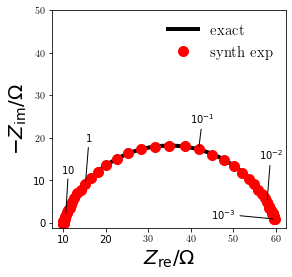

In [3]:
# Nyquist plot of impedance together with labeled frequency points
fig, ax = plt.subplots()
plt.plot(np.real(Z_exact), -np.imag(Z_exact), linewidth=4, color="black", label="exact")
plt.plot(np.real(Z_exp), -np.imag(Z_exp), "o", markersize=10, color="red", label="synth exp")
plt.annotate(r'$10^{-3}$', xy=(np.real(Z_exp[0]), -np.imag(Z_exp[0])), 
             xytext=(np.real(Z_exp[0])-15, -np.imag(Z_exp[0])), 
             arrowprops=dict(arrowstyle="-",connectionstyle="arc"))
plt.annotate(r'$10^{-2}$', xy=(np.real(Z_exp[10]), -np.imag(Z_exp[10])), 
             xytext=(np.real(Z_exp[10])-2, 10-np.imag(Z_exp[10])), 
             arrowprops=dict(arrowstyle="-",connectionstyle="arc"))
plt.annotate(r'$10^{-1}$', xy=(np.real(Z_exp[20]), -np.imag(Z_exp[20])), 
             xytext=(np.real(Z_exp[20])-2, 6-np.imag(Z_exp[20])), 
             arrowprops=dict(arrowstyle="-",connectionstyle="arc"))
plt.annotate(r'$1$', xy=(np.real(Z_exp[30]), -np.imag(Z_exp[30])), 
             xytext=(np.real(Z_exp[30]), 10-np.imag(Z_exp[30])), 
             arrowprops=dict(arrowstyle="-",connectionstyle="arc"))
plt.annotate(r'$10$', xy=(np.real(Z_exp[40]), -np.imag(Z_exp[40])), 
             xytext=(np.real(Z_exp[40])-1, 10-np.imag(Z_exp[40])), 
             arrowprops=dict(arrowstyle="-",connectionstyle="arc"))
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.legend(frameon=False, fontsize = 15)
plt.axis('scaled')

plt.xticks(range(10, 70, 10))
plt.yticks(range(0, 60, 10))
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel(r'$Z_{\rm re}/\Omega$', fontsize = 20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)
plt.show()

## 3) Compute the optimal hyperparameters

In [4]:
# initialize the parameter for global 3D optimization to maximize the marginal log-likelihood as shown in eq (31)
sigma_n = sigma_n_exp
sigma_f = 5.
ell = 1.

theta_0 = np.array([sigma_n, sigma_f, ell])
seq_theta = np.copy(theta_0)
def print_results(theta):
    global seq_theta
    seq_theta = np.vstack((seq_theta, theta))
    print('{0:.7f}  {1:.7f}  {2:.7f}'.format(theta[0], theta[1], theta[2]))
    
GP_DRT.NMLL_fct(theta_0, Z_exp, xi_vec)
GP_DRT.grad_NMLL_fct(theta_0, Z_exp, xi_vec)
print('sigma_n,   sigma_f,   ell')

# minimize the NMLL L(\theta) w.r.t sigma_n, sigma_f, ell using the Newton-CG method as implemented in scipy
res = minimize(GP_DRT.NMLL_fct, theta_0, args=(Z_exp, xi_vec), method='Newton-CG', \
               jac=GP_DRT.grad_NMLL_fct,  callback=print_results, options={'disp': True})

# collect the optimized parameters
sigma_n, sigma_f, ell = res.x

sigma_n,   sigma_f,   ell
0.1050094  5.0001097  0.9994337
0.1048101  5.0107903  0.9481658
0.1047302  5.0306225  0.8953989
0.1047554  5.2374445  0.9106815
0.1047249  5.6762153  0.9284003
0.1047301  5.7952355  0.9351541
0.1047294  5.8025362  0.9355971
0.1047297  5.8025365  0.9355918
Optimization terminated successfully.
         Current function value: -68.171912
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 62
         Hessian evaluations: 0


## 4) Core of the GP-DRT

### 4a) Compute matrices

In [5]:
# calculate the matrices shown in eq (18)
K = GP_DRT.matrix_K(xi_vec, xi_vec, sigma_f, ell)
L_im_K = GP_DRT.matrix_L_im_K(xi_vec, xi_vec, sigma_f, ell)
L2_im_K = GP_DRT.matrix_L2_im_K(xi_vec, xi_vec, sigma_f, ell)
Sigma = (sigma_n**2)*np.eye(N_freqs)

### 4b) Factorize the matrices and solve the linear equations

In [6]:
# the matrix $\mathcal L^2_{\rm im} \mathbf K + \sigma_n^2 \mathbf I$ whose inverse is needed
K_im_full = L2_im_K + Sigma

# Cholesky factorization, L is a lower-triangular matrix
L = np.linalg.cholesky(K_im_full)

# solve for alpha
alpha = np.linalg.solve(L, Z_exp.imag)
alpha = np.linalg.solve(L.T, alpha)

# estimate the gamma of eq (21a), the minus sign, which is not included in L_im_K, refers to eq (65)
gamma_fct_est = -np.dot(L_im_K.T, alpha)

# covariance matrix
inv_L = np.linalg.inv(L)
inv_K_im_full = np.dot(inv_L.T, inv_L)
inv_K_im_full2 = np.linalg.inv(K_im_full)

# estimate the sigma of gamma for eq (21b)
cov_gamma_fct_est = K - np.dot(L_im_K.T, np.dot(inv_K_im_full, L_im_K))
sigma_gamma_fct_est = np.sqrt(np.diag(cov_gamma_fct_est))

### 4c) Predict the imaginary part of the GP-DRT and impedance

In [7]:
# initialize the imaginary part of impedance vector
Z_im_vec_star = np.empty_like(xi_vec_star)
Sigma_Z_im_vec_star = np.empty_like(xi_vec_star)

gamma_vec_star = np.empty_like(xi_vec_star)
Sigma_gamma_vec_star = np.empty_like(xi_vec_star)

# calculate the imaginary part of impedance at each $\xi$ point for the plot
for index, val in enumerate(xi_vec_star):
    xi_star = np.array([val])

    # compute matrices shown in eq (18), k_star corresponds to a new point
    k_star = GP_DRT.matrix_K(xi_vec, xi_star, sigma_f, ell)
    L_im_k_star = GP_DRT.matrix_L_im_K(xi_vec, xi_star, sigma_f, ell) #; L_im_k_star = L_im_k_star.T
    L2_im_k_star = GP_DRT.matrix_L2_im_K(xi_star, xi_vec, sigma_f, ell); L2_im_k_star= L2_im_k_star.T
    k_star_star = GP_DRT.matrix_K(xi_star, xi_star, sigma_f, ell)
    L_im_k_star_star = GP_DRT.matrix_L_im_K(xi_star, xi_star, sigma_f, ell)
    L2_im_k_star_star = GP_DRT.matrix_L2_im_K(xi_star, xi_star, sigma_f, ell)

    # compute Z_im_star mean and standard deviation using eq (26)
    Z_im_vec_star[index] = np.dot(L2_im_k_star.T,np.dot(inv_K_im_full,Z_exp.imag))
    Sigma_Z_im_vec_star[index] = L2_im_k_star_star-np.dot(L2_im_k_star.T, np.dot(inv_K_im_full, L2_im_k_star))
    
    # compute Z_im_star mean and standard deviation
    gamma_vec_star[index] = -np.dot(L_im_k_star.T,np.dot(inv_K_im_full,Z_exp.imag))
    Sigma_gamma_vec_star[index] = k_star_star-np.dot(L_im_k_star.T, np.dot(inv_K_im_full, L_im_k_star))

### 4d) Plot the obtained GP-DRT against the analytical DRT
Note: we can see the prediction credibility interval broadening at low frequencies

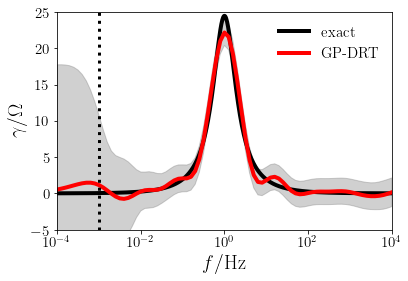

In [8]:
# plot the DRT and its confidence region
plt.semilogx(freq_vec_plot, gamma_fct_plot, linewidth=4, color="black", label="exact")
plt.semilogx(freq_vec_star, gamma_vec_star, linewidth=4, color="red", label="GP-DRT")
plt.semilogx([1E-3, 1E-3], [-5, 25], ':', linewidth=3, color="black")
plt.fill_between(freq_vec_star, gamma_vec_star-3*np.sqrt(abs(Sigma_gamma_vec_star)), gamma_vec_star+3*np.sqrt(abs(Sigma_gamma_vec_star)), color="0.4", alpha=0.3)
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.axis([1E-4,1E4,-5,25])
plt.legend(frameon=False, fontsize = 15)
plt.xlabel(r'$f/{\rm Hz}$', fontsize = 20)
plt.ylabel(r'$\gamma/\Omega$', fontsize = 20)
plt.show()

### 4e) Plot the imaginary part of the GP-DRT impedance together with the exact one and the synthetic experiment
Note: we can see the prediction credibility interval broadening at low frequencies

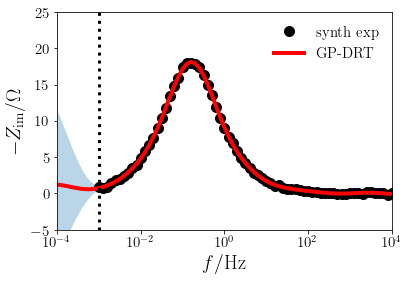

In [9]:
plt.semilogx(freq_vec, -Z_exp.imag, "o", markersize=10, color="black", label="synth exp")
plt.semilogx(freq_vec_star, -Z_im_vec_star, linewidth=4, color="red", label="GP-DRT")
plt.semilogx([1E-3, 1E-3], [-5, 25], ':', linewidth=3, color="black")
plt.fill_between(freq_vec_star, -Z_im_vec_star-3*np.sqrt(abs(Sigma_Z_im_vec_star)), -Z_im_vec_star+3*np.sqrt(abs(Sigma_Z_im_vec_star)), alpha=0.3)
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.axis([1E-4,1E4,-5,25])
plt.legend(frameon=False, fontsize = 15)
plt.xlabel(r'$f/{\rm Hz}$', fontsize = 20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)
plt.show()